<a href="https://colab.research.google.com/github/Kamaljit12/Brain-tumor-Prediction-CNN/blob/main/Analysis_started.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# !pip install kaggle

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
fileName = "BrainTumorPreTrainedModel"

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets list -s 'brain tumor datasets'

ref                                                               title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
davidbroberts/brain-tumor-object-detection-datasets               Brain tumor object detection datasets                12MB  2021-10-04 02:36:32           3577         49  0.875            
masoudnickparvar/brain-tumor-mri-dataset                          Brain Tumor MRI Dataset                             149MB  2021-09-24 12:43:45          74403        671  0.875            
trainingdatapro/computed-tomography-ct-of-the-brain               Computed Tomography (CT) of the Brain                66MB  2023-10-13 15:17:47           3782         59  1.0              
awsaf49/brats20-dataset-training-validation       

In [7]:
# download datasets
!kaggle datasets download -d 'masoudnickparvar/brain-tumor-mri-dataset'

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 95% 141M/149M [00:01<00:00, 149MB/s]
100% 149M/149M [00:01<00:00, 139MB/s]


In [8]:
## unzip
import zipfile
zip_ref = zipfile.ZipFile('/content/brain-tumor-mri-dataset.zip', 'r')
zip_ref.extractall('/content/data')
zip_ref.close()

In [9]:
## load this image datasets
import tensorflow as tf

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory('/content/data/Training',
                                                       image_size=(256, 256))

val_ds = tf.keras.utils.image_dataset_from_directory('/content/data/Testing',
                                                     image_size=(256, 256))

Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


In [11]:
len(train_ds), len(val_ds)

(179, 41)

In [12]:
labels = train_ds.class_names
print(labels)

['glioma', 'meningioma', 'notumor', 'pituitary']


In [ ]:
# train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
# val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
labels = []
for image, label in train_ds.as_numpy_iterator():
  labels.append(label)

In [14]:
ls = []
for i in labels:
  for j in i:
    ls.append(j)

In [15]:
import numpy as np
import pandas as pd

arr = np.array(ls)
pd.DataFrame(arr).value_counts()

## there is no imballencing

,count
0,
2,1595
3,1457
1,1339
0,1321


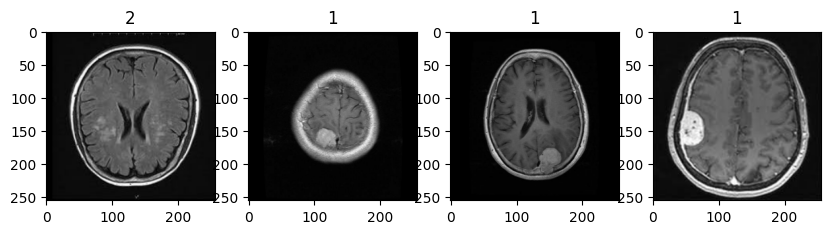

In [16]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(ncols=4,figsize=(10, 4))

batch = train_ds.shuffle(5).as_numpy_iterator().next()

for index, image in enumerate(batch[0][:4]):
  ax[index].imshow(image.astype(int))
  ax[index].title.set_text(batch[1][index])
plt.show()

In [17]:
def process(image, label):
  image = tf.image.resize(image, (256, 256))
  return image, label

train_ds = train_ds.map(process)
val_ds = val_ds.map(process)

In [18]:
num_of_class = len(np.unique(train_ds.as_numpy_iterator().next()[1]))

In [19]:
## trian the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization

model = Sequential([
    Conv2D(32, kernel_size=(3,3), strides=2, activation='relu', padding='valid',input_shape=(256, 256, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    Conv2D(64, (3,3), strides=2, padding='valid',activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    Conv2D(128, (3,3), strides=2, padding='valid',activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dropout(0.4),
    Dense(num_of_class, activation='softmax')

])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 127, 127, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 127, 127, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 31, 31, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 31, 31, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 15, 15, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 15, 15, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 7, 7, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             1

 Total params: 252,196 (985.14 KB)

 Trainable params: 251,748 (983.39 KB)

 Non-trainable params: 448 (1.75 KB)

In [21]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [22]:
## fit and train the model
history = model.fit(train_ds, epochs=15, validation_data=val_ds)

Epoch 1/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 32s 113ms/step - accuracy: 0.3543 - loss: 1.6192 - val_accuracy: 0.5889 - val_loss: 0.9925
Epoch 2/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 25s 71ms/step - accuracy: 0.5991 - loss: 0.9951 - val_accuracy: 0.6392 - val_loss: 0.8777
Epoch 3/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 19s 64ms/step - accuracy: 0.6727 - loss: 0.8443 - val_accuracy: 0.6377 - val_loss: 0.8928
Epoch 4/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 22s 71ms/step - accuracy: 0.7007 - loss: 0.7720 - val_accuracy: 0.7109 - val_loss: 0.6829
Epoch 5/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 19s 66ms/step - accuracy: 0.7311 - loss: 0.7106 - val_accuracy: 0.6575 - val_loss: 0.9554
Epoch 6/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 12s 67ms/step - accuracy: 0.7505 - loss: 0.6294 - val_accuracy: 0.7506 - val_loss: 0.5739
Epoch 7/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 21s 71ms/step - accuracy: 0.7632 - loss: 0.6244 - val_accuracy: 0.7605 - val_loss: 0.5801
Epoch 8/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 19s 64ms/step - accuracy: 0.7882 - loss: 0.5633 -

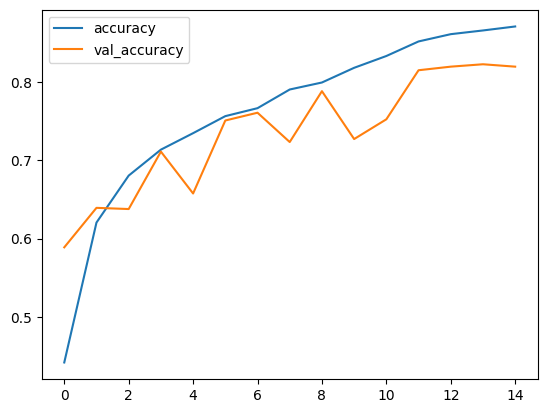

In [23]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

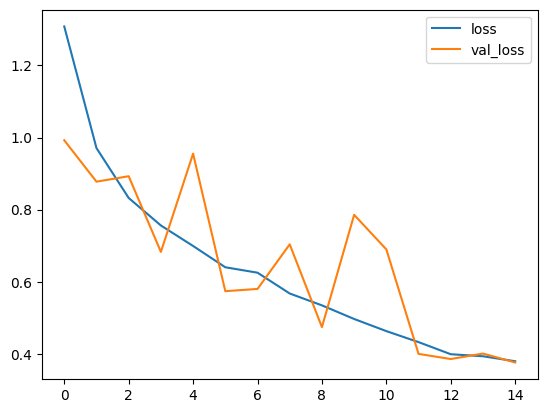

In [24]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [25]:
## test the model
test_ds = tf.keras.utils.image_dataset_from_directory('/content/data/Testing',
                                                       image_size=(256, 256))

Found 1311 files belonging to 4 classes.


In [26]:
batch = test_ds.as_numpy_iterator().next()

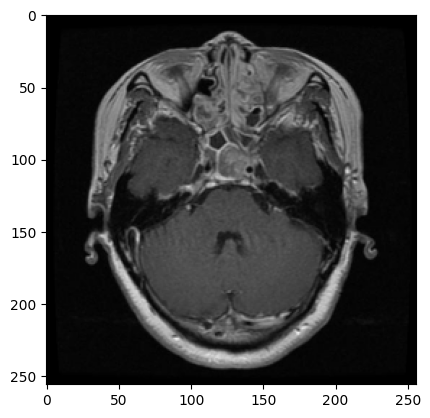

In [27]:
img = batch[0][1]
img_label = batch[1][1]
plt.imshow(img.astype(int))
plt.show()

In [28]:
image = tf.image.resize(img, (256, 256))
image = tf.expand_dims(image, 0)

In [29]:
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

In [30]:
prediction = model.predict(image)
index = np.argmax(prediction)
print(f"Predicted: {labels[index]}")
print(f"Actual: {labels[img_label]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
Predicted: pituitary
Actual: pituitary


In [33]:
model.save(f'/content/drive/MyDrive/BrainTumor/brainTumorPreTrainedModel.keras')

In [36]:
import pickle

with open("/content/drive/MyDrive/BrainTumor/BrainTumorCnnModel.pkl", "wb") as f:
  pickle.dump(model, f)

In [37]:
with open("/content/drive/MyDrive/BrainTumor/BrainTumorCnnModel.pkl", "rb") as f:
  new_model = pickle.load(f)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 22 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [38]:
prediction = new_model.predict(image)
index = np.argmax(prediction)
print(f"Predicted: {labels[index]}")
print(f"Actual: {labels[img_label]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
Predicted: pituitary
Actual: pituitary


In [39]:
new_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 127, 127, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 127, 127, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 31, 31, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 31, 31, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 15, 15, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 15, 15, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 7, 7, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             1

 Total params: 503,946 (1.92 MB)

 Trainable params: 251,748 (983.39 KB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 251,750 (983.40 KB)